<a href="https://colab.research.google.com/github/GMobinit/cat_dog_recognition_model/blob/VGG_model/cat_dog_recognition_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
! pip install kaggle

In [7]:
## Upload your kaggle credentials to content directroy
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! kaggle datasets download karakaggle/kaggle-cat-vs-dog-dataset

Dataset URL: https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset
License(s): unknown
 98% 770M/787M [00:03<00:00, 131MB/s] 
100% 787M/787M [00:03<00:00, 215MB/s]


In [9]:
import tensorflow as tf
import zipfile

In [10]:
zipfile.ZipFile('kaggle-cat-vs-dog-dataset.zip', 'r').extractall('dataset')

In [11]:
import pathlib
data_dir = pathlib.Path('dataset/kagglecatsanddogs_3367a/PetImages').with_suffix('')

In [12]:
cat_image_count = len(list(data_dir.glob('Cat/*')))
dog_image_count = len(list(data_dir.glob('Dog/*')))
print(f"cat image count: {cat_image_count}, dog image count: {dog_image_count}, all images: {cat_image_count+dog_image_count}")

cat image count: 12491, dog image count: 12470, all images: 24961


In [13]:
import PIL

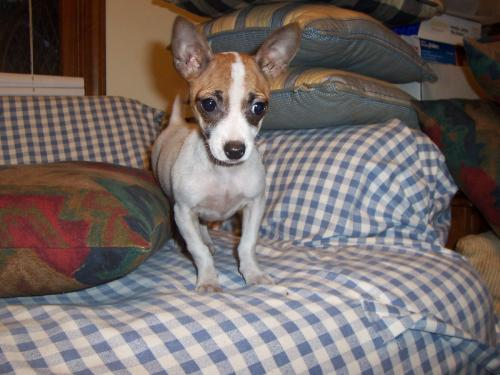

In [14]:
PIL.Image.open(str(list(data_dir.glob('Dog/*'))[0]))

In [15]:
list_ds  = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(cat_image_count+dog_image_count, reshuffle_each_iteration=False)

In [61]:
for file_add in list_ds.take(5):
  print(file_add)

tf.Tensor(b'dataset/kagglecatsanddogs_3367a/PetImages/Dog/7411.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/kagglecatsanddogs_3367a/PetImages/Cat/8554.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/kagglecatsanddogs_3367a/PetImages/Dog/492.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/kagglecatsanddogs_3367a/PetImages/Cat/2312.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/kagglecatsanddogs_3367a/PetImages/Dog/10300.jpg', shape=(), dtype=string)


In [17]:
labels = []
for item in data_dir.glob('*'):
  labels.append(item.name)

print(labels)

['Dog', 'Cat']


In [18]:
## train validation split
validation_percentage = 0.2
validation_size = int((cat_image_count+dog_image_count)*validation_percentage)

validation_ds = list_ds.take(validation_size)
train_ds = list_ds.skip(validation_size)

print(f'validation size {tf.data.experimental.cardinality(validation_ds)}, train size {len(train_ds)}')

validation size 4992, train size 19969


In [44]:
import os
def get_label(file_path):
  separated_path = tf.strings.split(file_path, os.path.sep)
  label = separated_path[-2]
  one_hotted_label = (label == labels)
  return tf.argmax(one_hotted_label)

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [45]:
batch_size = 32
img_height = 180
img_width = 180

In [54]:
def decode_img(encoded_img):
  img = tf.io.decode_image(encoded_img, channels=3, expand_animations=False)
  img = tf.image.resize(img, (img_height, img_width))
  return img

In [55]:
def process_path(img_path):
  label = get_label(img_path)
  img = tf.io.read_file(img_path)
  img = decode_img(img)
  return img, label

In [ ]:
process_path('dataset/kagglecatsanddogs_3367a/PetImages/Dog/7411.jpg')

In [57]:
AUTOTUNE = tf.data.AUTOTUNE

mapped_train_ds = train_ds.map(map_func= process_path,num_parallel_calls=AUTOTUNE)
mapped_validation_ds = validation_ds.map(map_func=process_path, num_parallel_calls=AUTOTUNE)

In [63]:
for image, label in mapped_train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Image label: ", label.numpy())

Image shape:  (180, 180, 3)
Image label:  0
Image shape:  (180, 180, 3)
Image label:  0
Image shape:  (180, 180, 3)
Image label:  0
Image shape:  (180, 180, 3)
Image label:  1
Image shape:  (180, 180, 3)
Image label:  0


In [102]:
def configure_for_performance(ds: tf.data.Dataset):
  # ds = dataset.cache()
  ds = ds.shuffle(buffer_size=500)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [103]:
high_performance_train_ds = configure_for_performance(mapped_train_ds)
high_performance_validation_ds = configure_for_performance(mapped_validation_ds)

In [104]:
for a,b in high_performance_train_ds.take(1):
  print(a.shape)
  print(b.numpy())

(32, 180, 180, 3)
[1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1]


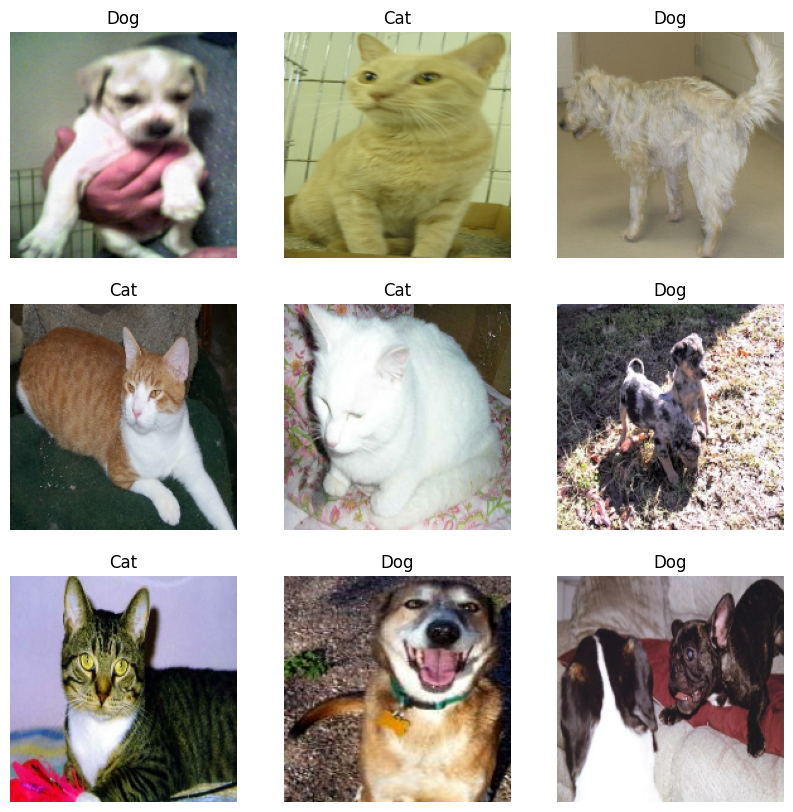

In [105]:
import matplotlib.pyplot as plt

for image_batch, label_batch in high_performance_train_ds.take(1):

  plt.figure(figsize=(10,10))
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint32"))
    label = label_batch[i]
    plt.title(labels[label])
    plt.axis("off")

In [106]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(180,180,3))

In [107]:
base_model.trainable = False

In [108]:
flatten_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(100, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [109]:
model = tf.keras.models.Sequential([
  base_model,
  flatten_layer,
  dense_layer,
  dropout_layer,
  prediction_layer
])

In [110]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss = tf.keras.losses.BinaryCrossentropy, metrics=['acc'])

In [111]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,766,089 (56.33 MB)

 Trainable params: 51,401 (200.79 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [113]:
model.fit(high_performance_train_ds, epochs=100, validation_data=high_performance_validation_ds)

Epoch 1/100
 41/625 ━━━━━━━━━━━━━━━━━━━━ 1:23 143ms/step - acc: 0.9283 - loss: 0.3920

InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Error in user-defined function passed to ParallelMapDatasetV2:6 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: Input size should match (header_size + row_size * abs_height) but they differ by 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  Error in user-defined function passed to ParallelMapDatasetV2:6 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: Input size should match (header_size + row_size * abs_height) but they differ by 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_8703]